# TRF-NET
#### This is made for Face Recognition derived from ResNet50 Architecture

## MODULES REQUIRED

In [48]:
# === Built-in Modules ===
import os                            # For file path management and directory traversal
import random                        # For random sampling

# === Numerical and Array Handling ===
import numpy as np                   # For numerical operations and array handling
from collections import defaultdict  # For grouping items by key

# === Image Handling ===
from PIL import Image                # For image loading and manipulation (optional backup to OpenCV/PIL)
import cv2                           # For image reading and resizing (OpenCV)
import glob                          # For pattern-based file search (e.g., *.jpg)

# === Progress Visualization ===
from tqdm import tqdm                # To show progress bars for loops (useful for preprocessing)

# === TensorFlow & Keras ===
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses  # Core components
from tensorflow.keras.models import Model                        # Model subclassing
from tensorflow.keras.layers import Layer                        # Custom layer creation
from tensorflow.keras.preprocessing.image import load_img, img_to_array  # Image utilities

# === Evaluation Metrics ===
from sklearn.metrics.pairwise import cosine_similarity  # To compare embedding vectors
from sklearn.metrics import accuracy_score, roc_auc_score  # Classification evaluation metrics


## PREPROCESING

In [49]:
def get_image_paths_and_labels(root_dir):
    """
    Scans a directory of person-named subfolders and returns:
    - List of image file paths
    - Corresponding numeric labels
    - Mapping of person names to labels
    """

    image_paths = []  # Stores all image file paths (clean + distorted)
    labels = []       # Stores corresponding numeric labels
    person_names = sorted(os.listdir(root_dir))  # Get all folder names (person identities)

    # Map each person name to a unique integer label
    person_to_label = {name: idx for idx, name in enumerate(person_names)}

    # Loop through each person's folder
    for person in person_names:
        person_folder = os.path.join(root_dir, person)
        if not os.path.isdir(person_folder):
            continue  # Skip if not a folder (just in case)

        # 1️⃣ Load clean images directly inside the person's folder
        clean_images = glob.glob(os.path.join(person_folder, "*.jpg"))

        # 2️⃣ Load distorted images inside the "distortion" subfolder (if it exists)
        distortion_folder = os.path.join(person_folder, "distortion")
        distorted_images = glob.glob(os.path.join(distortion_folder, "*.jpg")) if os.path.exists(distortion_folder) else []

        # 3️⃣ Combine all image paths (clean + distorted)
        all_images = clean_images + distorted_images
        label = person_to_label[person]  # Assign label based on person name

        # 4️⃣ Store each image and its label
        for img in all_images:
            image_paths.append(img)
            labels.append(label)

    # Return image paths, labels, and the name-to-label mapping
    return image_paths, labels, person_to_label


In [50]:
# === Define the path to the training dataset folder ===
train_dir = "train"  # Actual training directory path

# === Get all image file paths and corresponding labels ===
# - image_paths: list of all image file paths (clean + distorted)
# - labels: corresponding integer labels for classification
# - class_map: mapping from person names to numeric labels
image_paths, labels, class_map = get_image_paths_and_labels(train_dir)

# === Display basic dataset statistics ===
print(f"Total images: {len(image_paths)}")          # Total number of images found
print(f"Total unique persons: {len(class_map)}")    # Number of distinct person classes (folders)


Total images: 15408
Total unique persons: 878


In [51]:
# === Define the path to the validation dataset folder ===
val_dir = "val"  # Path to your validation dataset directory

# === Extract image paths, labels, and class mapping for the validation set ===
# - val_image_paths: List of all image file paths in the val set
# - val_labels: Corresponding numeric labels for each image
# - val_class_map: Dictionary mapping class names (folder names) to label integers
val_image_paths, val_labels, val_class_map = get_image_paths_and_labels(val_dir)

# === Print basic statistics of the validation dataset ===
print(f"[val] Total images: {len(val_image_paths)}")      # Total number of images in val set
print(f"[val] Total classes: {len(val_class_map)}")       # Number of unique identities (classes)


[val] Total images: 3376
[val] Total classes: 250


## TRIPLET PREPROCESSING

In [52]:
def make_triplets(image_paths, labels):
    """
    Generates triplets for training with triplet loss:
    - Anchor: clean image
    - Positive: distorted version of the anchor image
    - Negative: clean image of a different person

    Assumes the following folder structure:
    train/
        Person_01/
            img_01.jpg               ← clean
            distortion/
                img_01_blur.jpg      ← distorted
                img_01_fog.jpg
    """

    # === 1. Group images by label into clean and distorted categories ===
    label_to_clean = defaultdict(list)       # Dictionary to store clean images per label
    label_to_distorted = defaultdict(list)   # Dictionary to store distorted images per label

    for path, label in zip(image_paths, labels):
        # Store all image paths initially as clean
        label_to_clean[label].append(path)

        # Extract folder of the image
        img_folder = os.path.dirname(path)
        base_name = os.path.splitext(os.path.basename(path))[0]  # e.g., 'img_01'
        
        # Construct path to potential distortion folder (e.g., train/Person_01/distortion)
        distortion_folder = os.path.join(img_folder, 'distortion')

        # If distortion folder exists
        if os.path.exists(distortion_folder):
            # Look for all distorted versions of the current base image
            distorted = [
                os.path.join(distortion_folder, f)
                for f in os.listdir(distortion_folder)
                if base_name in f  # Matches pattern like 'img_01_blur.jpg'
            ]

            # If distorted images found, store them as positive candidates
            if distorted:
                label_to_distorted[label].append((path, distorted))

    # === 2. Generate triplets using the clean/distorted dictionaries ===
    triplets = []
    label_list = list(label_to_clean.keys())  # All available labels

    for label in label_list:
        if not label_to_distorted[label]:
            continue  # Skip labels that have no distorted images

        # For each clean image with at least one distorted match
        for clean_img, distorted_list in label_to_distorted[label]:
            anchor = clean_img                          # Anchor = clean image
            positive = random.choice(distorted_list)    # Positive = one of its distortions

            # Pick a label that's different from current label (for negative sample)
            negative_label = random.choice([l for l in label_list if l != label])
            negative = random.choice(label_to_clean[negative_label])  # Negative = clean image of another person

            # Store the triplet
            triplets.append((anchor, positive, negative))

    return triplets  # Final list of (anchor, positive, negative) image path triplets


In [53]:
# === Generate Triplets for Training ===
triplets = make_triplets(image_paths, labels)  # Creates (anchor, positive, negative) triplets from the dataset

# === Preview a Sample Triplet for Verification ===
print("Example triplet:")
print("Anchor:", triplets[0][0])    # Path to the clean (anchor) image
print("Positive:", triplets[0][1])  # Path to the distorted version of the same person (positive)
print("Negative:", triplets[0][2])  # Path to a clean image of a different person (negative)


Example triplet:
Anchor: train\001_frontal\001_frontal.jpg
Positive: train\001_frontal\distortion\001_frontal_rainy.jpg
Negative: train\Robert_Ehrlich\distortion\Robert_Ehrlich_0001_resized.jpg


In [54]:
# === Load and preprocess a single image ===
def load_image(path):
    """
    Reads and preprocesses an image from the given file path.
    - Reads the image as a binary file
    - Decodes it as a JPEG image with 3 color channels
    - Resizes it to 224x224 (ResNet50 input size)
    - Normalizes pixel values to the range [0, 1]
    """
    image = tf.io.read_file(path)                            # Read image file as byte string
    image = tf.image.decode_jpeg(image, channels=3)          # Decode JPEG to tensor
    image = tf.image.resize(image, [224, 224])               # Resize to model input shape
    image = tf.cast(image, tf.float32) / 255.0               # Normalize to float32 [0, 1]
    return image

# === Preprocess an entire triplet of images ===
def preprocess_triplet(anchor_path, positive_path, negative_path):
    """
    Given paths to anchor, positive, and negative images,
    loads and preprocesses all three into tensors.
    Returns a tuple of (anchor, positive, negative) tensors.
    """
    anchor = load_image(anchor_path)
    positive = load_image(positive_path)
    negative = load_image(negative_path)
    return (anchor, positive, negative)


In [55]:
def create_triplet_dataset(triplets, batch_size=32):
    """
    Creates a TensorFlow dataset for training with triplet loss.
    
    Args:
        triplets: A list of (anchor_path, positive_path, negative_path) tuples
        batch_size: Number of triplets per training batch
    
    Returns:
        A tf.data.Dataset object that yields batches of preprocessed triplets
    """

    # Unpack the list of triplets into three separate lists: anchors, positives, and negatives
    anchor_paths, positive_paths, negative_paths = zip(*triplets)

    # Create a dataset of image paths (still as strings)
    dataset = tf.data.Dataset.from_tensor_slices(
        (list(anchor_paths), list(positive_paths), list(negative_paths))
    )

    # Map the preprocessing function to load and transform image paths to tensors
    dataset = dataset.map(
        lambda a, p, n: preprocess_triplet(a, p, n),  # (anchor, positive, negative) tensors
        num_parallel_calls=tf.data.AUTOTUNE           # Enables parallel loading
    )

    # Shuffle the dataset and batch it
    dataset = dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset


In [56]:
# === Create the Triplet Dataset ===
triplet_dataset = create_triplet_dataset(triplets, batch_size=32)
# This prepares the dataset for training with triplet loss by batching and preprocessing

# === Preview One Batch from the Dataset ===
for batch in triplet_dataset.take(1):  # Take one batch to inspect
    anchor_batch, positive_batch, negative_batch = batch  # Unpack the triplet batch
    print("Anchor shape:", anchor_batch.shape)            # Expected: (batch_size, 224, 224, 3)
    print("Positive shape:", positive_batch.shape)        # Expected: (batch_size, 224, 224, 3)
    print("Negative shape:", negative_batch.shape)        # Expected: (batch_size, 224, 224, 3)


Anchor shape: (32, 224, 224, 3)
Positive shape: (32, 224, 224, 3)
Negative shape: (32, 224, 224, 3)


In [57]:
val_dir = "val"  # Path to the validation dataset directory

# === Get Validation Image Paths and Labels ===
# This function returns:
# - val_image_paths: list of image file paths
# - val_labels: list of corresponding labels (e.g., class/person IDs)
# - val_class_map: a dictionary mapping class names to label integers
val_image_paths, val_labels, val_class_map = get_image_paths_and_labels(val_dir)

# === Print Dataset Statistics ===
print(f"[val] Total images: {len(val_image_paths)}")  # Number of validation images
print(f"[val] Total classes: {len(val_class_map)}")   # Number of unique classes


[val] Total images: 3376
[val] Total classes: 250


In [58]:
# === Generate Triplets from Validation Dataset ===
val_triplets = make_triplets(val_image_paths, val_labels)
# Uses the same logic as training to generate (anchor, positive, negative) triplets from validation set

# === Display Number of Triplets Generated ===
print(f"Generated {len(val_triplets)} triplets from val set")
# Helpful for confirming that triplets are formed correctly and there are enough samples


Generated 422 triplets from val set


In [59]:
# === Create the Triplet Dataset for Validation ===
val_triplet_dataset = create_triplet_dataset(triplets, batch_size=32)
# This function prepares the validation triplet dataset with preprocessed images
# Each element is a batch of (anchor, positive, negative) triplets

# === Preview One Batch of Validation Data ===
for batch in val_triplet_dataset.take(1):  # Take just one batch for inspection
    anchor_batch, positive_batch, negative_batch = batch  # Unpack the batch
    print("Anchor shape:", anchor_batch.shape)            # Expected shape: (batch_size, 224, 224, 3)
    print("Positive shape:", positive_batch.shape)        # Same as above
    print("Negative shape:", negative_batch.shape)        # Same as above

# This helps confirm that the dataset pipeline is functioning correctly.


Anchor shape: (32, 224, 224, 3)
Positive shape: (32, 224, 224, 3)
Negative shape: (32, 224, 224, 3)


In [60]:
# === Add Dummy Labels to Triplet Dataset ===
def add_dummy_labels(dataset):
    """
    Adds dummy labels to the triplet dataset.
    This is required to satisfy the Keras .fit() function,
    which expects both inputs and labels.

    Args:
        dataset: tf.data.Dataset of (anchor, positive, negative) triplets

    Returns:
        A new dataset of ((anchor, positive, negative), dummy_label)
    """
    return dataset.map(
        lambda a, p, n: ((a, p, n), tf.zeros((tf.shape(a)[0],)))  # Add dummy labels with same batch size
    )

# === Apply to Validation and Training Sets ===
val_triplet_dataset_with_labels = add_dummy_labels(val_triplet_dataset)
train_triplet_dataset_with_labels = add_dummy_labels(triplet_dataset)
# These datasets now have the structure expected by model.fit()


## MODEL

In [61]:
def se_block(input_tensor, reduction=16):
    """
    Implements a Squeeze-and-Excitation (SE) block.
    
    Args:
        input_tensor: Input feature map (batch, H, W, C)
        reduction: Reduction ratio for the intermediate Dense layer (usually 16)
    
    Returns:
        Output tensor after channel-wise reweighting
    """
    
    # Get number of channels from the input tensor shape
    channels = input_tensor.shape[-1]

    # === SQUEEZE ===
    # Global Average Pooling across spatial dimensions (H, W) → shape becomes (batch, C)
    x = layers.GlobalAveragePooling2D()(input_tensor)

    # === EXCITATION ===
    # Fully connected layer with reduction to bottleneck the channel dimension
    x = layers.Dense(channels // reduction, activation='relu')(x)

    # Restore back to original number of channels using sigmoid for weights (between 0 and 1)
    x = layers.Dense(channels, activation='sigmoid')(x)

    # Reshape to match dimensions for broadcasting → (batch, 1, 1, C)
    x = layers.Reshape((1, 1, channels))(x)

    # === SCALE ===
    # Multiply channel-wise weights with the original input tensor
    return layers.Multiply()([input_tensor, x])


In [62]:
class CBAM(Layer):
    def __init__(self, reduction=16, **kwargs):
        super(CBAM, self).__init__(**kwargs)
        self.reduction = reduction  # Channel reduction ratio for bottleneck MLP

    def build(self, input_shape):
        self.channels = input_shape[-1]  # Number of channels in input

        # === Shared MLP for Channel Attention ===
        # Applies to both average and max pooled vectors
        self.shared_dense = tf.keras.Sequential([
            layers.Dense(self.channels // self.reduction, activation='relu'),
            layers.Dense(self.channels)
        ])

        # === Spatial Attention Convolution ===
        # 7x7 conv layer with sigmoid activation to get spatial attention map
        self.spatial_conv = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')

    def call(self, inputs):
        # ===== CHANNEL ATTENTION =====
        # Global average and max pooling to generate descriptors
        avg_pool = layers.GlobalAveragePooling2D()(inputs)  # shape: (batch, C)
        max_pool = layers.GlobalMaxPooling2D()(inputs)      # shape: (batch, C)

        # Apply shared MLP to both
        avg_out = self.shared_dense(avg_pool)  # shape: (batch, C)
        max_out = self.shared_dense(max_pool)  # shape: (batch, C)

        # Combine and apply sigmoid activation to get channel attention weights
        channel = layers.Add()([avg_out, max_out])            # shape: (batch, C)
        channel = layers.Activation('sigmoid')(channel)
        channel = layers.Reshape((1, 1, self.channels))(channel)  # reshape for broadcasting

        # Apply channel attention
        x = layers.Multiply()([inputs, channel])  # shape: (batch, H, W, C)

        # ===== SPATIAL ATTENTION =====
        # Average and max pooling along the channel axis
        avg_pool_spatial = tf.reduce_mean(x, axis=-1, keepdims=True)  # shape: (batch, H, W, 1)
        max_pool_spatial = tf.reduce_max(x, axis=-1, keepdims=True)   # shape: (batch, H, W, 1)

        # Concatenate along channel dimension
        spatial = layers.Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])  # shape: (batch, H, W, 2)

        # Apply spatial attention convolution
        spatial = self.spatial_conv(spatial)  # shape: (batch, H, W, 1)

        # Multiply input with spatial attention map
        return layers.Multiply()([x, spatial])  # Final output after CBAM


In [63]:
# === Load pretrained ResNet50 (without top classifier) ===
base_model = tf.keras.applications.ResNet50(
    include_top=False,        # Exclude final dense classification layer
    weights='imagenet',       # Use ImageNet pretrained weights
    input_shape=(224, 224, 3) # Input shape for face images
)
base_model.trainable = False  # Freeze ResNet50 layers to retain pretrained features

# === Feature extractor output ===
x = base_model.output  # Output of the last convolutional block from ResNet50

# === Custom enhancement CNN block + SE + CBAM ===
# Add custom Conv2D layer to enhance local features
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

# Apply Squeeze-and-Excitation block for channel attention
x = se_block(x)

# Apply CBAM block for combined channel + spatial attention
x = CBAM()(x)

# Additional convolution for refinement
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

# Global pooling to flatten the feature maps
x = layers.GlobalAveragePooling2D()(x)

# === Final dense layer to produce embedding ===
# 128-dimensional embedding vector
x = layers.Dense(128, activation='relu')(x)

# Apply dropout to prevent overfitting
x = layers.Dropout(0.4)(x)

# L2 normalize the embeddings so they lie on a unit hypersphere
embedding = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)

# === Final embedding model ===
# Input: image | Output: 128-d normalized embedding vector
embedding_model = tf.keras.Model(inputs=base_model.input, outputs=embedding)


## LOSS FUNCTION

In [64]:
# === Triplet Loss Function ===
# margin: Hyperparameter that defines how far apart the negative should be from the anchor compared to the positive

def triplet_loss(margin=0.2):
    
    def _loss(y_true, y_pred):
        # y_pred shape: (batch_size, 3, embedding_dim)
        # Each triplet contains 3 embeddings: [anchor, positive, negative]
        
        anchor = y_pred[:, 0, :]   # Extract anchor embeddings
        positive = y_pred[:, 1, :] # Extract positive embeddings (same identity as anchor)
        negative = y_pred[:, 2, :] # Extract negative embeddings (different identity)
        
        # Calculate squared Euclidean distance between anchor and positive
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
        
        # Calculate squared Euclidean distance between anchor and negative
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
        
        # Triplet loss = max(pos_dist - neg_dist + margin, 0)
        # Encourages the anchor-positive distance to be smaller than anchor-negative by at least the margin
        loss = tf.maximum(pos_dist - neg_dist + margin, 0.0)
        
        # Return average loss over the batch
        return tf.reduce_mean(loss)
    
    return _loss


In [65]:
# === Custom Accuracy Metric for Triplet Loss ===
# Measures how often the positive is closer to the anchor than the negative

class TripletAccuracy(tf.keras.metrics.Metric):
    
    def __init__(self, name="triplet_accuracy", **kwargs):
        super().__init__(name=name, **kwargs)
        
        # Initialize variables to track correct predictions and total samples
        self.correct = self.add_weight(name="correct", initializer="zeros")
        self.total = self.add_weight(name="total", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Split the predicted embeddings into anchor, positive, and negative
        anchor   = y_pred[:, 0, :]  # Shape: (batch_size, embedding_dim)
        positive = y_pred[:, 1, :]
        negative = y_pred[:, 2, :]

        # Calculate squared Euclidean distances
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)  # distance between anchor and positive
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)  # distance between anchor and negative

        # Count how many times positive distance is smaller than negative (correct triplets)
        correct = tf.reduce_sum(tf.cast(pos_dist < neg_dist, tf.float32))

        # Update metric state
        self.correct.assign_add(correct)
        self.total.assign_add(tf.cast(tf.shape(anchor)[0], tf.float32))  # Add batch size to total

    def result(self):
        # Return accuracy as correct / total
        return self.correct / self.total

    def reset_states(self):
        # Reset metric state between epochs
        self.correct.assign(0.0)
        self.total.assign(0.0)


In [66]:
from tensorflow.keras.layers import Lambda
from tensorflow.keras import Input, Model

# === Build Triplet Network ===
# Accepts 3 inputs: anchor, positive, and negative images
# Uses the same embedding model for all three branches (weight sharing)
# Outputs stacked embeddings for calculating triplet loss

def build_triplet_model(embedding_model):
    # Define 3 input layers for anchor, positive, and negative images
    input_anchor = Input(shape=(224, 224, 3), name="anchor")
    input_positive = Input(shape=(224, 224, 3), name="positive")
    input_negative = Input(shape=(224, 224, 3), name="negative")

    # Pass all 3 inputs through the shared embedding model
    emb_anchor = embedding_model(input_anchor)
    emb_positive = embedding_model(input_positive)
    emb_negative = embedding_model(input_negative)

    # Stack the 3 embeddings along a new dimension (axis=1)
    # Resulting shape: (batch_size, 3, embedding_dim)
    stacked_output = Lambda(lambda x: tf.stack(x, axis=1))(
        [emb_anchor, emb_positive, emb_negative]
    )

    # Create and return the final triplet model
    return Model(
        inputs=[input_anchor, input_positive, input_negative],
        outputs=stacked_output
    )


In [67]:
# === Build the Triplet Network ===
# `embedding_model` is a base model that encodes input images into feature vectors
triplet_net = build_triplet_model(embedding_model)

# === Compile the Model ===
triplet_net.compile(
    optimizer='adam',                       # Adam optimizer for efficient gradient updates
    loss=triplet_loss(margin=0.2),          # Custom triplet loss function with margin
    metrics=[TripletAccuracy()]             # Custom metric that evaluates how often anchor-positive < anchor-negative
)


In [68]:
# === Train the Triplet Network ===
history = triplet_net.fit(
    train_triplet_dataset_with_labels,  # Input dataset with ((anchor, positive, negative), dummy_label) format
    epochs=10                           # Train the model for 10 full passes over the dataset
)


Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1041s 16s/step - loss: 0.2369 - triplet_accuracy: 0.4878
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 967s 16s/step - loss: 0.2144 - triplet_accuracy: 0.5110
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1031s 16s/step - loss: 0.2128 - triplet_accuracy: 0.4828
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1043s 17s/step - loss: 0.2163 - triplet_accuracy: 0.4929
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1106s 17s/step - loss: 0.2149 - triplet_accuracy: 0.5080
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1051s 17s/step - loss: 0.2114 - triplet_accuracy: 0.4887
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1028s 16s/step - loss: 0.2123 - triplet_accuracy: 0.4904
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 975s 16s/step - loss: 0.2056 - triplet_accuracy: 0.5239
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 965s 16s/step - loss: 0.2013 - triplet_accuracy: 0.5306
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1019s 16s/step - loss: 0.2064 - triplet_accuracy: 0.4948


KeyError: 'val_triplet_accuracy'

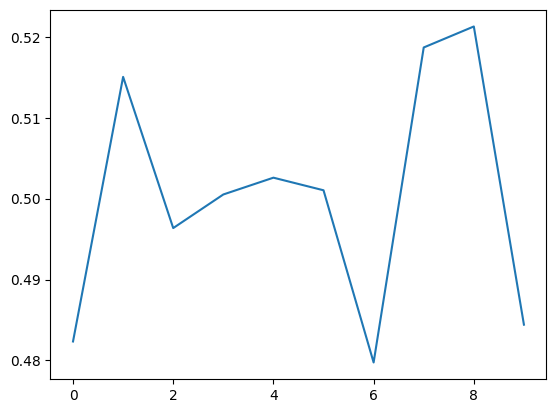

In [69]:
import matplotlib.pyplot as plt  # 📊 For plotting graphs

# === Plot Training Accuracy and Loss ===
plt.plot(history.history['triplet_accuracy'], label='Train Accuracy')  # 📈 Plot triplet accuracy over epochs
plt.plot(history.history['loss'], label='Train Loss')                  # 📉 Plot loss over epochs

# === Add Plot Labels and Decorations ===
plt.xlabel("Epochs")              # 🏷️ X-axis shows number of epochs
plt.ylabel("Value")               # 🏷️ Y-axis shows metric value (accuracy or loss)
plt.legend()                      # 📌 Display legend for clarity
plt.title("Training Metrics")     # 📝 Title of the plot
plt.grid(True)                    # 🔳 Add a grid for better readability

# === Show the plot ===
plt.show()


In [70]:
def get_embedding(model, image_path):
    # === Load and Preprocess the Image ===
    image = tf.io.read_file(image_path)                      # 📂 Read image file as raw bytes
    image = tf.image.decode_jpeg(image, channels=3)          # 🖼️ Decode JPEG image to tensor with 3 channels (RGB)
    image = tf.image.resize(image, [224, 224])               # 📏 Resize image to 224x224 to match model input
    image = tf.cast(image, tf.float32) / 255.0               # 🧼 Normalize pixel values to [0, 1]
    image = tf.expand_dims(image, axis=0)                    # ➕ Add batch dimension (shape becomes [1, 224, 224, 3])

    # === Extract Embedding using the Model ===
    embedding = model(image)                                # 🔍 Pass image through model to get embedding vector
    return tf.squeeze(embedding).numpy()                    # 🔽 Remove batch dimension and return as NumPy array


In [71]:
# === Cosine Similarity ===
def cosine_similarity(emb1, emb2):
    dot = np.dot(emb1, emb2)                               # 🔘 Compute dot product between two embeddings
    norm = np.linalg.norm(emb1) * np.linalg.norm(emb2)     # 📏 Compute product of their magnitudes (L2 norms)
    return dot / norm                                      # ➗ Return cosine similarity (value between -1 and 1)
# === Euclidean Distance ===
def euclidean_distance(emb1, emb2):
    return np.linalg.norm(emb1 - emb2)                     # 📏 Compute L2 distance (straight-line distance between points)


In [72]:
def find_closest_face(test_embedding, reference_db, threshold=0.5):
    best_match = None
    best_score = -1  # ✅ Initialize with worst similarity score (cosine similarity ranges from -1 to 1)

    # 🔍 Loop through each entry in the reference database
    for name, ref_embedding in reference_db.items():
        score = cosine_similarity(test_embedding, ref_embedding)  # 📏 Compute similarity between test and reference
        if score > best_score:
            best_match = name     # 🎯 Update best match if this score is better
            best_score = score    # 📝 Track the highest similarity

    # ✅ Return best match if similarity exceeds the threshold
    if best_score >= threshold:
        return best_match, best_score
    else:
        return "Unknown", best_score   # ❌ Return 'Unknown' if no match is confident enough


## SCORES

In [73]:
def compute_class_centroids(image_paths_by_class, model):
    class_centroids = {}  # 🧠 Dictionary to store the centroid (mean embedding) for each class

    # 🔁 Loop through each class and its corresponding image paths
    for class_name, image_paths in image_paths_by_class.items():
        # 📌 Compute embeddings for each image in the class
        embeddings = [get_embedding(model, p) for p in image_paths]

        # 📊 Compute the mean embedding (centroid) for the class
        class_centroids[class_name] = np.mean(embeddings, axis=0)

    return class_centroids  # 🔁 Return dictionary of class: centroid pairs


In [74]:
def predict_class(test_path, model, reference_db):
    # 📷 Step 1: Generate embedding for the test image
    test_embedding = get_embedding(model, test_path)

    # 📏 Step 2: Compute cosine similarity between test image and all reference embeddings
    similarities = {
        class_name: cosine_similarity(test_embedding, emb)
        for class_name, emb in reference_db.items()
    }

    # 🏆 Step 3: Return the class name with the highest similarity score (Top-1 match)
    return max(similarities.items(), key=lambda x: x[1])[0]


In [75]:

# 📦 Create a dictionary to store clean (non-distorted) image paths per class/person
reference_data = defaultdict(list)

# 🔁 Loop over all image paths from the val dataset
for path in val_image_paths:
    # 🚫 Filter out distorted images (case-insensitive check)
    if "distortion" not in path.lower():
        # 🏷️ Extract class/label name from the parent folder name (e.g., 'Person_01')
        label = os.path.basename(os.path.dirname(path))

        # 📥 Group image path under its class label
        reference_data[label].append(path)

# ✅ Convert defaultdict to a standard Python dictionary for usability
reference_data = dict(reference_data)

In [76]:
reference_db = {}

# 🔁 Iterate through each label (person/class) and their associated clean images
for label, img_list in reference_data.items():
    # 📷 Select the first clean image from the list for this class
    img_path = img_list[0]

    # 🔐 Generate the embedding vector using the trained embedding model
    reference_db[label] = get_embedding(embedding_model, img_path)

In [77]:
# 🔀 Randomly select one image path from the validation dataset
test_path = random.choice(val_image_paths)

# 🧠 Predict the class of the selected image using the trained embedding model
#     - Computes embedding for test image
#     - Compares with reference_db (known class embeddings)
#     - Returns the class with highest cosine similarity
predicted_class = predict_class(test_path, embedding_model, reference_db)

# 🖨️ Output the predicted class label to the console
print("Predicted class:", predicted_class)


Predicted class: 009_frontal


In [81]:

reference_embeddings = compute_class_centroids(reference_data, embedding_model)

def evaluate(model, val_data, reference_embeddings):
    y_true = []
    y_pred = []

    for path in val_data:
        label = os.path.basename(os.path.dirname(path))  # True label from folder name
        pred = predict_class(path, model, reference_embeddings)

        y_true.append(label)
        y_pred.append(pred)

    # 🧮 Top-1 Accuracy
    top1 = np.mean(np.array(y_true) == np.array(y_pred))

    # 🧮 Macro F1-score
    f1_macro = f1_score(y_true, y_pred, average='macro')

    return top1, f1_macro

# 📊 === Run Evaluation ===
reference_embeddings = compute_class_centroids(reference_data, embedding_model)
top1, f1_macro = evaluate(embedding_model, val_image_paths, reference_embeddings)

print(f"Top-1 Accuracy: {top1:.4f}")
print(f"Macro-averaged F1-Score: {f1_macro:.4f}")
print(f"Top-1 Accuracy: {top1:.4f}")
print(f"Macro-averaged F1-Score: {f1_macro:.4f}")


KeyboardInterrupt: 

In [ ]:
# 📋 Print the architecture of the Triplet Network model
triplet_net.summary()

In [ ]:
# 🧠 Show the architecture of the embedding model
embedding_model.summary()

In [ ]:
# 🔍 Loop through each layer in the triplet model
for layer in triplet_net.layers:
    print(f"Layer: {layer.name}")  # 🧩 Print the name of the current layer

    # 🔢 Get the weights (if any) associated with this layer
    weights = layer.get_weights()

    # 📏 Loop through each weight tensor (kernel, bias, etc.)
    for i, w in enumerate(weights):
        print(f"  Weight {i}: shape={w.shape}")  # 📐 Print shape of each weight


In [83]:
# 💾 Save the entire triplet network model (architecture + weights + optimizer state)
triplet_net.save("triplet_network_model.h5")

In [84]:
# 💾 Save the face embedding model (ResNet50 + custom layers) for future use
# This includes the architecture, weights, and training config (if any)
embedding_model.save("face_embedding_model.h5")